# Order data of mexican style franchise chipotle data analysis

## data analysis overview
### What is most popular menu?

We have to summarize question list like below
- What are the top 10 of most sold menus?
- How much of sales count for each menu?
- How much price range of each menu?

I will solve this problem by python and SQL at the same time.  
First, i wil write by Python like book and second i will write by SQL(MySQL v8.0)

In [1]:
# for connect MySQL
import pymysql
conn = pymysql.connect(host='localhost', port=3306, user='data_analysis_book', passwd='D@taanalysis1', db='this_is_data_analysis', charset='utf8')

# Show data information

In [2]:
# data load and show information of chipotle
import pandas as pd
file_path = '../data/chipotle.tsv'
chipotle_data = pd.read_csv(file_path, sep='\t')

print(f'Chipo.shape >> {chipotle_data.shape}')
print('----')
print('Chipo data information')
print(chipotle_data.info())

Chipo.shape >> (4622, 5)
----
Chipo data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 5 columns):
order_id              4622 non-null int64
quantity              4622 non-null int64
item_name             4622 non-null object
choice_description    3376 non-null object
item_price            4622 non-null object
dtypes: int64(2), object(3)
memory usage: 180.7+ KB
None


Chipotle data has 4,622 rows and 5 features(columns).  
In chipotle_data.info() we can know like as below:
- Feature name which name is 'choice_description' has 1,246(4,622 - 3,376) missing values.
- 'order_id', 'quantity' types is integer.
- 'choice_description', 'item_name', 'item_price' types is string.

In [3]:
# show 10 row order by dataframe index
chipotle_data.head(10)

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98
5,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",$10.98
6,3,1,Side of Chips,NaN,$1.69
7,4,1,Steak Burrito,"[Tomatillo Red Chili Salsa, [Fajita Vegetables...",$11.75
8,4,1,Steak Soft Tacos,"[Tomatillo Green Chili Salsa, [Pinto Beans, Ch...",$9.25
9,5,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Pinto...",$9.25


In [4]:
print(f'Columns : {chipotle_data.columns}')
print(f'Index : {chipotle_data.index}')

Columns : Index(['order_id', 'quantity', 'item_name', 'choice_description',
       'item_price'],
      dtype='object')
Index : RangeIndex(start=0, stop=4622, step=1)


Chipo data's feature meaning:
- order_id : order number(can duplicate because it means customers order's id(one customer can order lots of thing)
- quantity : quantity of ordered item
- item_name : name of ordered item
- choice_description : detail selected option of ordered item
- item_price : price of ordered item

**Numerical character of quantity and item_price**  
- Both features are continuous features.
    - Continuous feature means it can get any value shape of continuous number like heights, weights.
- We can get basic statistics by describe()
    - Function which name is describe, gives only quantity's information because numerical feature is only quantity
    - order_id is numerical too, but it is number to seperate order.
    - item_price is string value in this data.
    

In [5]:
# change order_id to string because it didn't have numerical meaning
# we don't change sql data to string(it will be dangerous)
chipotle_data['order_id'] = chipotle_data['order_id'].astype(str)
chipotle_data.describe()

,quantity
count,4622.000000
mean,1.075725
std,0.410186
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


In [6]:
# Blog said it need set group_concat_max_len =10485760
# https://using.tistory.com/91
# To do : Change query to get quantile

query_for_describe = """
select
    count(quantity) as "count",
    avg(quantity) as "mean",
    std(quantity) as "std",
    min(quantity) as "min",
    substring_index(substring_index(group_concat(quantity order by quantity separator  ','), ',', 0.25*count(*) + 1), ',' , -1) as "25%",
    substring_index(substring_index(group_concat(quantity order by quantity separator  ','), ',', 0.5*count(*) + 1), ',' , -1) as "median",
    substring_index(substring_index(group_concat(quantity order by quantity separator  ','), ',', 0.75*count(*) + 1), ',' , -1) as "75%",
    max(quantity) as "max"
from chipotle"""
describe_result = pd.read_sql(query_for_describe, conn)
describe_result.T

/Users/h/opt/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1260, 'Row 513 was cut by GROUP_CONCAT()')
  result = self._query(query)


,0
count,4622
mean,1.0757
std,0.410142
min,1
25%,
median,
75%,
max,15


In [7]:
# Changed Query by row_num
# Question : why difference std() in mysql and pandas
query_for_describe="""
with quantity_with_row_number as (
    select quantity, row_number() over (partition by quantity order by quantity) as row_num, total.cnt as total
    from chipotle, (select count(quantity) as cnt from chipotle) as total
    where chipotle.quantity is not null
    order by quantity
)
select
    count(quantity) as "count",
    avg(quantity) as "mean",
    std(quantity) as "std",
    min(quantity) as "min",
    sum(case when row_num = round(total*0.25) then quantity else 0 end) as "25%",
    sum(case when row_num = round(total*0.5) then quantity else 0 end) as "50%",
    sum(case when row_num = round(total*0.75) then quantity else 0 end) as "75%",
    max(quantity) as "max"
from quantity_with_row_number
"""
describe_result = pd.read_sql(query_for_describe, conn)
describe_result.T

,0
count,4622.000000
mean,1.075700
std,0.410142
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


In [8]:
# dataframe describe division by n-1
print(chipotle_data['quantity'].std())
print(chipotle_data['quantity'].std(ddof=0))

0.4101863342575426
0.41014195860595415


We can get insight by describe as below:
- Average of quantity is 1.07.
    - It means "Almost customers ordered 1 item for 1 menu.".
    - We can get insight like "There are not many cases where one person purchases multiple items of the same menu.".

**Number of order_id, item_name**  
We can get as below:

In [9]:
print(len(chipotle_data['order_id'].unique()))
print(len(chipotle_data['item_name'].unique()))

1834
50


In [10]:
cur = conn.cursor()
query_for_order_id_cnt = "select count(distinct order_id) from chipotle;"
cur.execute(query_for_order_id_cnt)
print(cur.fetchmany(1))
query_for_item_name_cnt = "select count(distinct item_name) from chipotle;"
cur.execute(query_for_item_name_cnt)
print(cur.fetchmany(1))
cur.close()

((1834,),)
((50,),)


## Navigation and visualization for get insight

### top 10 of most sold menus


In [11]:
# in book method
item_count = chipotle_data['item_name'].value_counts()[:10]
for idx, (val, cnt) in enumerate(item_count.iteritems(), 1):
    print(f"Top {idx} : {val}, {cnt}")

Top 1 : Chicken Bowl, 726
Top 2 : Chicken Burrito, 553
Top 3 : Chips and Guacamole, 479
Top 4 : Steak Burrito, 368
Top 5 : Canned Soft Drink, 301
Top 6 : Chips, 211
Top 7 : Steak Bowl, 211
Top 8 : Bottled Water, 162
Top 9 : Chicken Soft Tacos, 115
Top 10 : Chips and Fresh Tomato Salsa, 110


In [12]:
# by group by
grouped_item_count = chipotle_data.groupby('item_name')['item_name'].count()
print(grouped_item_count.sort_values(ascending=False).iloc[:10])

item_name
Chicken Bowl           726
Chicken Burrito        553
Chips and Guacamole    479
Steak Burrito          368
Canned Soft Drink      301
Steak Bowl             211
Chips                  211
Bottled Water          162
Chicken Soft Tacos     115
Chicken Salad Bowl     110
Name: item_name, dtype: int64


In [13]:
# by SQL
query_for_top10="""
select item_name, count(item_name) as cnt
from chipotle
group by 1
order by 2 desc
limit 10;
"""
item_rank_by_query = pd.read_sql(query_for_top10, conn)
item_rank_by_query

,item_name,cnt
0,Chicken Bowl,726
1,Chicken Burrito,553
2,Chips and Guacamole,479
3,Steak Burrito,368
4,Canned Soft Drink,301
5,Chips,211
6,Steak Bowl,211
7,Bottled Water,162
8,Chicken Soft Tacos,115
9,Chips and Fresh Tomato Salsa,110


### Order count and total quantity for each menu


In [14]:
# get order count for each menu
order_count = chipotle_data.groupby('item_name')['order_id'].count()
order_count[:10]

item_name
6 Pack Soft Drink         54
Barbacoa Bowl             66
Barbacoa Burrito          91
Barbacoa Crispy Tacos     11
Barbacoa Salad Bowl       10
Barbacoa Soft Tacos       25
Bottled Water            162
Bowl                       2
Burrito                    6
Canned Soda              104
Name: order_id, dtype: int64

In [15]:
# by SQL
query_for_order_count="""
select item_name, count(order_id) as cnt
from chipotle
group by 1
order by 1;
"""
order_count_by_query = pd.read_sql(query_for_order_count, conn)
order_count_by_query[:10]

,item_name,cnt
0,6 Pack Soft Drink,54
1,Barbacoa Bowl,66
2,Barbacoa Burrito,91
3,Barbacoa Crispy Tacos,11
4,Barbacoa Salad Bowl,10
5,Barbacoa Soft Tacos,25
6,Bottled Water,162
7,Bowl,2
8,Burrito,6
9,Canned Soda,104


In [16]:
# total quantity for each item
item_quantity = chipotle_data.groupby('item_name')['quantity'].sum()
item_quantity[:10]

item_name
6 Pack Soft Drink         55
Barbacoa Bowl             66
Barbacoa Burrito          91
Barbacoa Crispy Tacos     12
Barbacoa Salad Bowl       10
Barbacoa Soft Tacos       25
Bottled Water            211
Bowl                       4
Burrito                    6
Canned Soda              126
Name: quantity, dtype: int64

In [17]:
# by sql
query_for_item_quantity="""
select item_name, sum(quantity) as cnt
from chipotle
group by 1
order by 1;
"""
item_quantity_by_query = pd.read_sql(query_for_item_quantity, conn)
item_quantity_by_query[:10]

,item_name,cnt
0,6 Pack Soft Drink,55.0
1,Barbacoa Bowl,66.0
2,Barbacoa Burrito,91.0
3,Barbacoa Crispy Tacos,12.0
4,Barbacoa Salad Bowl,10.0
5,Barbacoa Soft Tacos,25.0
6,Bottled Water,211.0
7,Bowl,4.0
8,Burrito,6.0
9,Canned Soda,126.0


### Visualization


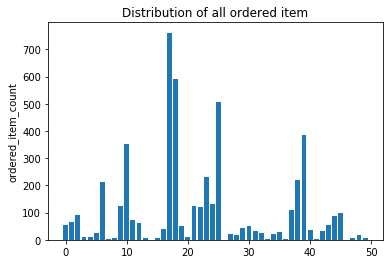

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

item_name_list = item_quantity.index.tolist()
x_pos = np.arange(len(item_name_list))
order_cnt = item_quantity.values.tolist()

plt.bar(x_pos, order_cnt, align='center')
plt.ylabel('ordered_item_count')
plt.title('Distribution of all ordered item')
plt.show()

**Quiz 1-1**  
What is difference value_counts() and unique()?

> My Answer  
>   - value_counts() give name, count per name in same time.  
>   - unique() give unique name.
  
  
Answer in book
- value_counts() is a function that returns the category of all data appearing in the series object along with the respective count, and unique() returns only the category of all data.

## Data peprocessing - Use preprocessing function


In [19]:
chipotle_data['item_price'].head(10)

0     $2.39 
1     $3.39 
2     $3.39 
3     $2.39 
4    $16.98 
5    $10.98 
6     $1.69 
7    $11.75 
8     $9.25 
9     $9.25 
Name: item_price, dtype: object

item_price type is string but we want to change decimal.  
Before the preprocessing, we can find item_price is not decimal because The \$ sign is prepended to the number representing the price.

In [20]:
# change by apply and lambda
chipotle_data['item_price'] = chipotle_data['item_price'].apply(lambda x : float(x[1:]))
chipotle_data.describe()

,quantity,item_price
count,4622.000000,4622.000000
mean,1.075725,7.464336
std,0.410186,4.245557
min,1.000000,1.090000
25%,1.000000,3.390000
50%,1.000000,8.750000
75%,1.000000,9.250000
max,15.000000,44.250000


In [21]:
# preprocessing by sql query
query_for_peprocessing = """
select
    cast(order_id as char) as order_id,
    quantity,
    item_name,
    choice_description,
    cast(substring(item_price from 2) as float ) as item_price
from chipotle
"""
chipotle_data_by_query = pd.read_sql(query_for_peprocessing, conn)
chipotle_data_by_query.describe()

,quantity,item_price
count,4622.000000,4622.000000
mean,1.075725,7.464336
std,0.410186,4.245557
min,1.000000,1.090000
25%,1.000000,3.390000
50%,1.000000,8.750000
75%,1.000000,9.250000
max,15.000000,44.250000


## Exploratory data analysis


### Average item price per order

In [22]:
chipotle_data.groupby('order_id')['item_price'].sum().mean()

18.811428571428717

In [23]:
query_for_average_item_price = """
select
    sum(cast(substring(item_price from 2) as float )) / count(distinct order_id) as average
from chipotle
"""
cur = conn.cursor()
cur.execute(query_for_average_item_price)
print(cur.fetchmany(1))
cur.close()

((18.811428571428824,),)


### Print order id which paid more or equal than 10 dollars per order

In [24]:
chipo_orderid_group = chipotle_data.groupby('order_id').sum()
results = chipo_orderid_group[chipo_orderid_group.item_price >= 10]
print(results[:10])
print(results.index.values)

          quantity  item_price
order_id                      
1                4       11.56
10               2       13.20
100              2       10.08
1000             2       20.50
1001             2       10.08
1002             2       10.68
1003             2       13.00
1004             2       21.96
1005             3       12.15
1006             8       71.40
['1' '10' '100' ... '997' '998' '999']


In [25]:
query_for_over_than_10dollar = """
select
    cast(order_id as char) as order_id,
    sum(quantity) as quantity,
    sum(cast(substring(item_price from 2) as float ))as item_price
from chipotle
group by 1
having sum(cast(substring(item_price from 2) as float )) >= 10
order by 1
"""
paid_over_than_10dollar_by_query = pd.read_sql(query_for_over_than_10dollar, conn)
paid_over_than_10dollar_by_query.set_index(paid_over_than_10dollar_by_query['order_id'], inplace=True)
print(paid_over_than_10dollar_by_query[:10])
print(paid_over_than_10dollar_by_query.order_id.values)

         order_id  quantity  item_price
order_id                               
1               1       4.0       11.56
10             10       2.0       13.20
100           100       2.0       10.08
1000         1000       2.0       20.50
1001         1001       2.0       10.08
1002         1002       2.0       10.68
1003         1003       2.0       13.00
1004         1004       2.0       21.96
1005         1005       3.0       12.15
1006         1006       8.0       71.40
['1' '10' '100' ... '997' '998' '999']


### get price each item
In chipotle dataset, the price of each item should be inferred using only the data given.  
1. Select an order where only one item is purchased by use chipo[chipo.quantity == 1]
2. After group by item_name, calculate minimum price for each group.
3. Use function sort_values() for sort by item_price.

In [26]:
chipo_one_item = chipotle_data[chipotle_data.quantity == 1]
price_per_item = chipo_one_item.groupby('item_name').min()
price_per_item.sort_values(by='item_price', ascending=False)[:10]

,order_id,quantity,choice_description,item_price
item_name,,,,
Steak Salad Bowl,1032,1,"[Fresh Tomato Salsa, Lettuce]",9.39
Barbacoa Salad Bowl,1283,1,"[Fresh Tomato Salsa, Guacamole]",9.39
Carnitas Salad Bowl,1035,1,"[Fresh Tomato Salsa, [Rice, Black Beans, Chees...",9.39
Carnitas Soft Tacos,1011,1,"[Fresh Tomato Salsa (Mild), [Black Beans, Rice...",8.99
Carnitas Crispy Tacos,1774,1,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",8.99
Steak Soft Tacos,1054,1,"[Fresh Tomato Salsa (Mild), [Cheese, Sour Cream]]",8.99
Carnitas Salad,1500,1,"[[Fresh Tomato Salsa (Mild), Roasted Chili Cor...",8.99
Carnitas Bowl,1007,1,"[Fresh Tomato (Mild), [Guacamole, Lettuce, Ric...",8.99
Barbacoa Soft Tacos,1103,1,"[Fresh Tomato Salsa, [Black Beans, Cheese, Let...",8.99


In [27]:
query_for_price_per_item = """
select item_name,
       min(cast(substring(item_price from 2) as float)) as minimum_price
from chipotle
where quantity = 1
group by 1
order by 2 desc;
"""
price_per_item_by_query = pd.read_sql(query_for_price_per_item, conn)
price_per_item_by_query.head(10)

,item_name,minimum_price
0,Steak Salad Bowl,9.39
1,Carnitas Salad Bowl,9.39
2,Barbacoa Salad Bowl,9.39
3,Steak Soft Tacos,8.99
4,Carnitas Bowl,8.99
5,Carnitas Soft Tacos,8.99
6,Carnitas Salad,8.99
7,Barbacoa Crispy Tacos,8.99
8,Barbacoa Soft Tacos,8.99
9,Carnitas Crispy Tacos,8.99


In [28]:
# visualization
item_name_list = price_per_item.index.tolist()
x_pos = np.arange(len(item_name_list))
item_price = price_per_item['item_price'].tolist()

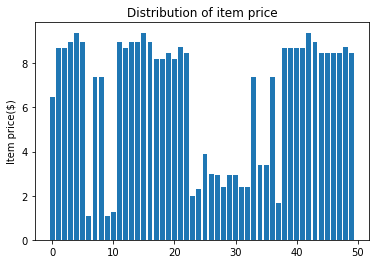

In [29]:
plt.bar(x_pos, item_price, align='center')
plt.ylabel('Item price($)')
plt.title('Distribution of item price')
plt.show()

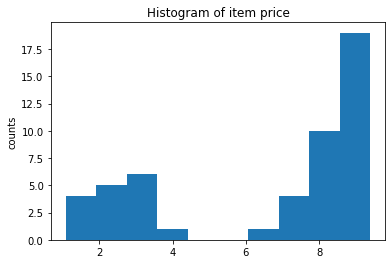

In [30]:
plt.hist(item_price)
plt.ylabel('counts')
plt.title('Histogram of item price')
plt.show()

We can get insight like below:
- The price of the item is priced at about 2-4 dollars, or about 6-8 dollars.


### Finding how many items were sold in the most expensive order


In [31]:
chipotle_data.groupby('order_id').sum().sort_values(by='item_price', ascending=False)[:5]

,quantity,item_price
order_id,,
926,23,205.25
1443,35,160.74
1483,14,139.00
691,11,118.25
1786,20,114.30


In [32]:
query_for_expensive_order="""
select
    order_id,
    sum(quantity) as quantity,
    sum(cast(substring(item_price from 2) as float)) as item_price
from chipotle
group by 1
order by 3 desc
"""
expensive_order_by_query = pd.read_sql(query_for_expensive_order, conn,index_col='order_id')
expensive_order_by_query[:5]

,quantity,item_price
order_id,,
926,23.0,205.25
1443,35.0,160.74
1483,14.0,139.00
691,11.0,118.25
1786,20.0,114.30


### Finding how many times the'Veggie Salad Bowl' was ordered


In [33]:
chipo_salad = chipotle_data[chipotle_data['item_name'] == 'Veggie Salad Bowl']
chipo_salad = chipo_salad.drop_duplicates(['item_name', 'order_id'])
print(len(chipo_salad))
chipo_salad.head(5)

18


,order_id,quantity,item_name,choice_description,item_price
186,83,1,Veggie Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25
295,128,1,Veggie Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Lettu...",11.25
455,195,1,Veggie Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25
496,207,1,Veggie Salad Bowl,"[Fresh Tomato Salsa, [Rice, Lettuce, Guacamole...",11.25
960,394,1,Veggie Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Lettu...",8.75


In [34]:
query_for_chipo_salad = """
select
    order_id,
    item_name
from chipotle
where item_name='Veggie Salad Bowl'
group by 1, 2
"""
chipo_salad_by_query = pd.read_sql(query_for_chipo_salad, conn)
print(len(chipo_salad_by_query))
chipo_salad_by_query.head(5)

18


,order_id,item_name
0,83,Veggie Salad Bowl
1,128,Veggie Salad Bowl
2,195,Veggie Salad Bowl
3,207,Veggie Salad Bowl
4,394,Veggie Salad Bowl


### Get the total order quantity of the "Chicken Bowl" menu from customers who have ordered more than one "Chicken Bowl

In [35]:
chipo_chicken = chipotle_data[chipotle_data['item_name']=='Chicken Bowl']
chipo_chicken_ordersum = chipo_chicken.groupby('order_id').sum()['quantity']
chipo_chicken_result = chipo_chicken_ordersum[chipo_chicken_ordersum >= 2]
print(len(chipo_chicken_result))
chipo_chicken_result.head(5)

114


order_id
1004    2
1023    2
1072    2
1078    2
1091    2
Name: quantity, dtype: int64

In [36]:
# by sql
query_for_chipo_chicken = """
select
    cast(order_id as char) as order_id,
    sum(quantity) as sum_quantity
from chipotle
where item_name='Chicken Bowl'
group by 1
having sum_quantity >= 2
order by 1
"""
chipo_chicken_result_by_query = pd.read_sql(query_for_chipo_chicken, conn, index_col='order_id')
print(len(chipo_chicken_result_by_query))
chipo_chicken_result_by_query.head(5)

114


,sum_quantity
order_id,
1004,2.0
1023,2.0
1072,2.0
1078,2.0
1091,2.0


### Find the number of orders for 2 or more'Chicken Bowls'

In [37]:
chipo_chicken = chipotle_data[chipotle_data['item_name']=='Chicken Bowl']
chipo_order_more_then_2 = chipo_chicken[chipo_chicken['quantity'] >= 2]
print(len(chipo_order_more_then_2))
chipo_order_more_then_2.head(5)

33


,order_id,quantity,item_name,choice_description,item_price
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98
154,70,2,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",17.50
282,124,2,Chicken Bowl,"[Fresh Tomato Salsa, [Rice, Black Beans, Chees...",17.50
409,178,3,Chicken Bowl,"[[Fresh Tomato Salsa (Mild), Tomatillo-Green C...",32.94
415,181,2,Chicken Bowl,[Tomatillo Red Chili Salsa],17.50


In [38]:
query_for_order_more_then_2 = """
select
    *
from chipotle
where 1=1
and item_name='Chicken Bowl'
and quantity >= 2
"""
chipo_order_more_then_2_by_query = pd.read_sql(query_for_order_more_then_2, conn)
print(len(chipo_order_more_then_2_by_query))
chipo_order_more_then_2_by_query.head(5)

33


,order_id,quantity,item_name,choice_description,item_price
0,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98
1,70,2,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",$17.50
2,124,2,Chicken Bowl,"[Fresh Tomato Salsa, [Rice, Black Beans, Chees...",$17.50
3,178,3,Chicken Bowl,"[[Fresh Tomato Salsa (Mild), Tomatillo-Green C...",$32.94
4,181,2,Chicken Bowl,[Tomatillo Red Chili Salsa],$17.50


## Data analysis by table
  
 Question | Feature | Insight 
 -- | -- | -- 
Most ordered item | item_name | Chicken Bowl is most popular item
All item types ordered | item_name | There are 50 ordered item in dataset
Total ordered quentity for each item | item_name | In 50 items, Orders are concentrated on the top 8 items
Average calculated price per order | item_price | Average is 18, std is 11
Approximate price of each item | item_price | Almost item price \\$ 2\~4 or \$ 6\~8

In [39]:
conn.close()